**A Keras-Tensorflow experimentation of Automatic Signature Verification Using Siamese Networks**

##### Import Libraries

In [1]:
import sys
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import time
import itertools
import random

import h5py
from keras import backend as K
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import models
from keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate, Dropout, BatchNormalization, MaxPooling2D, Concatenate, Lambda, Flatten, Dense, Layer
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())
# tf.debugging.set_log_device_placement(True)
print("Success")


Success


##### Making Dataset Ready for training

In [2]:
path_hindi = "C:/Users/hittu/Downloads/ml_project/extracted_files/BHSig260/Hindi"
dir_list = next(os.walk(path_hindi))[1]
dir_list.sort()

In [3]:
orig_groups, forg_groups = [], []
for directory in dir_list:
    images = os.listdir(path_hindi+'/'+directory)
    images.sort()
    images = [path_hindi+'/'+directory+'/'+x for x in images]
    forg_groups.append(images[:30]) # First 30 signatures in each folder are forrged
    orig_groups.append(images[30:]) # Next 24 signatures are genuine
    
# Quick check to confirm we have data of all the 50 individuals
print(len(orig_groups), len(forg_groups))

50 50


In [4]:
orig_lengths = [len(x) for x in orig_groups]
forg_lengths = [len(x) for x in forg_groups]
print(orig_lengths, forg_lengths)

[24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24] [30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30]


In [5]:
orig_train, orig_test, forg_train, forg_test = train_test_split(orig_groups, forg_groups, test_size=0.2, random_state=1)
orig_train, orig_val, forg_train, forg_val = train_test_split(orig_train, forg_train, test_size=0.25, random_state=1)

print(len(orig_train),len(orig_val),len(orig_test))

30 10 10


#### Train-Validation-Test Split
* Signatures of 96 people are used for training
* Signatures of 32 people are used for validation
* Signatures of 32 people are used for testing

In [6]:
# Delete unnecessary variables
del orig_groups, forg_groups

In [7]:
# All the images will be converted to the same size before processing
img_h, img_w = 155, 220

##### Generating Batches for training

In [8]:
def generate_batch(orig_groups, forg_groups, batch_size = 32):
    '''Function to generate a batch of data with batch_size number of data points
    Half of the data points will be Genuine-Genuine pairs and half will be Genuine-Forged pairs'''
    while True:
        orig_pairs = []
        forg_pairs = []
        gen_gen_labels = []
        gen_for_labels = []
        all_pairs = []
        all_labels = []

        # Here we create pairs of Genuine-Genuine image names and Genuine-Forged image names
        # For every person we have 24 genuine signatures, hence we have
        # 24 choose 2 = 276 Genuine-Genuine image pairs for one person.
        # To make Genuine-Forged pairs, we pair every Genuine signature of a person
        # with 12 randomly sampled Forged signatures of the same person.
        # Thus we make 30 * 12 = 360 Genuine-Forged image pairs for one person.
        # In all we have 120 person's data in the training data.
        # Total no. of Genuine-Genuine pairs = 30 * 276 = 8280
        # Total number of Genuine-Forged pairs = 30 * 300 = 9000
        # Total no. of data points = 8280+9000 = 17280
        for orig, forg in zip(orig_groups, forg_groups):
            orig_pairs.extend(list(itertools.combinations(orig, 2)))
            for i in range(len(forg)):
                forg_pairs.extend(list(itertools.product(orig[i:i+1], random.sample(forg, 10))))

        # Label for Genuine-Genuine pairs is 1
        # Label for Genuine-Forged pairs is 0
        gen_gen_labels = [1]*len(orig_pairs)
        gen_for_labels = [0]*len(forg_pairs)

        # Concatenate all the pairs together along with their labels and shuffle them
        all_pairs = orig_pairs + forg_pairs
        all_labels = gen_gen_labels + gen_for_labels
        del orig_pairs, forg_pairs, gen_gen_labels, gen_for_labels
        all_pairs, all_labels = shuffle(all_pairs, all_labels)

        # Note the lists above contain only the image names and
        # actual images are loaded and yielded below in batches
        # Below we prepare a batch of data points and yield the batch
        # In each batch we load "batch_size" number of image pairs
        # These images are then removed from the original set so that
        # they are not added again in the next batch.

        k = 0
        pairs=[np.zeros((batch_size, img_h, img_w, 1)) for i in range(2)]
        targets=np.zeros((batch_size,))
        for ix, pair in enumerate(all_pairs):
            img1 = cv2.imread(pair[0], 0)
            img2 = cv2.imread(pair[1], 0)
            img1 = cv2.resize(img1, (img_w, img_h))
            img2 = cv2.resize(img2, (img_w, img_h))
            img1 = np.array(img1, dtype = np.float64)
            img2 = np.array(img2, dtype = np.float64)
            img1 /= 255
            img2 /= 255
            img1 = img1[..., np.newaxis]
            img2 = img2[..., np.newaxis]
            pairs[0][k, :, :, :] = img1
            pairs[1][k, :, :, :] = img2
            targets[k] = all_labels[ix]
            k += 1
            if k == batch_size:
                yield pairs, targets
                k = 0
                pairs=[np.zeros((batch_size, img_h, img_w, 1)) for i in range(2)]
                targets=np.zeros((batch_size,))

##### Assets for Deep Learning

In [38]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))
def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)
def contrastive_loss(y_true, y_pred):
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)

##### The Main Architecture

In [39]:
def create_base_network_signet(input_shape):
    '''Base Siamese Network'''

    seq = Sequential()
    seq.add(Conv2D(96, (11, 11), activation='relu', strides=4, input_shape=input_shape,
                   kernel_initializer='glorot_uniform', data_format='channels_last'))
    seq.add(BatchNormalization(axis=-1, momentum=0.9))
    seq.add(MaxPooling2D((3, 3), strides=(2, 2)))
    seq.add(ZeroPadding2D((2, 2)))

    seq.add(Conv2D(256, (5, 5), activation='relu', kernel_initializer='glorot_uniform', data_format='channels_last'))
    seq.add(BatchNormalization(axis=-1, momentum=0.9))
    seq.add(MaxPooling2D((3, 3), strides=(2, 2)))
    seq.add(Dropout(0.3))
    seq.add(ZeroPadding2D((1, 1)))

    seq.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='glorot_uniform', data_format='channels_last'))
    seq.add(MaxPooling2D((3, 3), strides=(2, 2)))
    seq.add(Dropout(0.3))

    seq.add(Flatten())
    seq.add(Dense(1024, activation='relu', kernel_regularizer=l2(0.0005), kernel_initializer='glorot_uniform'))
    seq.add(Dropout(0.5))

    seq.add(Dense(128, activation='relu', kernel_regularizer=l2(0.0005), kernel_initializer='glorot_uniform'))

    return seq

In [40]:
input_shape=(img_h, img_w, 1)

In [41]:
# network definition
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    # Model definition needs to be inside the strategy scope
    base_network = create_base_network_signet(input_shape)

    input_a = Input(shape=input_shape)
    input_b = Input(shape=input_shape)

    processed_a = base_network(input_a)
    processed_b = base_network(input_b)

    distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed_a, processed_b])

    p_model = Model(inputs=[input_a, input_b], outputs=distance, name='head_model')

    # Ensure the optimizer and the loss function are defined within the scope
    rms = RMSprop(learning_rate=1e-4, rho=0.9, epsilon=1e-07, clipvalue=1.0)
    p_model.compile(loss=contrastive_loss, optimizer=rms)

p_model.summary()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Model: "head_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 155, 220, 1)]        0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None, 155, 220, 1)]        0         []                            
                                                                                                  
 sequential_2 (Sequential)   (None, 128)                  5282240   ['input_5[0][0]',             
                                                                     'input_6[0][0]']             
                                                                                      

In [42]:
batch_sz = 128
num_train_samples = 276*30 + 300*30 #Genuine-Genuine and Genuine-Forged pairs for training
num_val_samples = num_test_samples = 276*10 + 300*10  # Genuine-Genuine and Genuine-Forged for validation and test
num_train_samples, num_val_samples, num_test_samples

(17280, 5760, 5760)

In [43]:
# Using Keras Callbacks, save the model after every epoch
# Reduce the learning rate by a factor of 0.1 if the validation loss does not improve for 5 epochs
# Stop the training using early stopping if the validation loss does not improve for 15 epochs
callbacks = [
    EarlyStopping(patience=20, verbose=1, monitor='val_loss'),
    ReduceLROnPlateau(factor=0.1, patience=10, min_lr=1e-7, verbose=1, monitor='val_loss'),
    ModelCheckpoint('C:/Users/hittu/Downloads/ml_project/extracted_files/BHSig260/Weights_1/signet-bhsig260-full-xavier-{epoch:03d}.h5',monitor='val_loss', verbose=1, save_best_only=True,  save_weights_only=False)
]

##### Training

In [44]:
try:
    results = p_model.fit(
        generate_batch(orig_train, forg_train, batch_sz),
        steps_per_epoch=num_train_samples // batch_sz,
        epochs=50,
        validation_data=generate_batch(orig_val, forg_val, batch_sz),
        validation_steps=num_val_samples // batch_sz,
        callbacks=callbacks
    )
except tf.errors.InvalidArgumentError as e:
    if 'NaN' in str(e):
        print("NaN detected!")

Epoch 1/50
135/135 [==============================] - ETA: 0s - loss: 25.5062
Epoch 1: val_loss improved from inf to 1.36713, saving model to C:/Users/hittu/Downloads/ml_project/extracted_files/BHSig260/Weights_1\signet-bhsig260-full-xavier-001.h5
135/135 [==============================] - 500s 4s/step - loss: 25.5062 - val_loss: 1.3671 - lr: 1.0000e-04
Epoch 2/50
135/135 [==============================] - ETA: 0s - loss: 1.1973
Epoch 2: val_loss improved from 1.36713 to 1.33031, saving model to C:/Users/hittu/Downloads/ml_project/extracted_files/BHSig260/Weights_1\signet-bhsig260-full-xavier-002.h5
135/135 [==============================] - 489s 4s/step - loss: 1.1973 - val_loss: 1.3303 - lr: 1.0000e-04
Epoch 3/50
135/135 [==============================] - ETA: 0s - loss: 1.1119
Epoch 3: val_loss improved from 1.33031 to 1.29414, saving model to C:/Users/hittu/Downloads/ml_project/extracted_files/BHSig260/Weights_1\signet-bhsig260-full-xavier-003.h5
135/135 [==========================

In [45]:
def compute_accuracy_roc(predictions, labels, plot_far_frr =False):
    '''
    Compute ROC accuracy with a range of thresholds on distances.
    Plot FAR-FRR curves and P-R curves to monitor performance of model on input set.
    '''
    dmax = np.max(predictions)
    dmin = np.min(predictions)
    nsame = np.sum(labels == 1) #similar
    ndiff = np.sum(labels == 0) #different
    step = 0.01
    max_acc = 0
    best_thresh = -1
    frr_plot = []
    far_plot = []
    pr_plot = []
    re_plot = []
    ds = []
    for d in np.arange(dmin, dmax+step, step):
        idx1 = predictions.ravel() <= d #guessed genuine
        idx2 = predictions.ravel() > d #guessed forged
        tp = float(np.sum(labels[idx1] == 1))
        tn = float(np.sum(labels[idx2] == 0))
        fp = float(np.sum(labels[idx1] == 0))
        fn = float(np.sum(labels[idx2] == 1))
#         print(tp, tn, fp, fn)
        tpr = float(np.sum(labels[idx1] == 1)) / nsame
        tnr = float(np.sum(labels[idx2] == 0)) / ndiff


        acc = 0.5 * (tpr + tnr)
        pr = tp / (tp + fp)
        re = tp / (tp + fn)
#       print ('ROC', acc, tpr, tnr)

        if (acc > max_acc):
            max_acc, best_thresh = acc, d

        #if (fp+tn) != 0.0 and (fn+tp) != 0.0:
        far = fp / (fp + tn)
        frr = fn / (fn + tp)
        frr_plot.append(frr)
        pr_plot.append(pr)
        re_plot.append(re)
        far_plot.append(far)
        ds.append(d)


    if plot_far_frr:
        fig = plt.figure(figsize = (10,10))
        ax = fig.add_subplot(121)
        ax.plot(ds, far_plot, color = 'red')
        ax.plot(ds, frr_plot, color = 'blue')
        ax.set_title('Error rate')
        ax.legend(['FAR', 'FRR'])
        ax.set(xlabel = 'Thresholds', ylabel = 'Error rate')

        ax1 = fig.add_subplot(122)
        ax1.plot(ds, pr_plot, color = 'green')
        ax1.plot(ds, re_plot, color = 'magenta')
        ax1.set_title('P-R curve')
        ax1.legend(['Precision', 'Recall'])
        ax.set(xlabel = 'Thresholds', ylabel = 'Error rate')

        plt.show()
    return max_acc, best_thresh

#### Load the weights from the epoch which gave the best validation accuracy

In [46]:
def load_and_check_model(weight, model):
    """
    Print validation Accuracy for all saved weights and choose the best for test set
    (TODO - Perform Ensemble of Weights)
    """
    model.load_weights(weight)

    val_gen = generate_batch(orig_val, forg_val, 1)
    pred, tr_y = [], []
    for i in range(num_val_samples):
        (img1, img2), label = next(val_gen)
        tr_y.append(label)
        pred.append(model.predict([img1, img2])[0][0])

    tr_acc, threshold = compute_accuracy_roc(np.array(pred), np.array(tr_y))
    return tr_acc, threshold

#### BHSIG260 full dataset with Xavier Initialisation on Uniform Distribution

In [47]:
acc_thresh = []
weights_dir = 'C:/Users/hittu/Downloads/ml_project/extracted_files/BHSig260/Weights_1/'
weight_files = [f for f in os.listdir(weights_dir) if f.endswith('.h5')]

for weight_file in sorted(weight_files):
    weight_path = os.path.join(weights_dir, weight_file)
    tr_acc, threshold = load_and_check_model(weight_path, p_model)
    acc_thresh.append((tr_acc, threshold))
    model_number = weight_file.split('-')[-1].split('.')[0]  # Assuming the format is always 'signet-bhsig260-full-xavier-XXX.h5'
    print(f'For model {model_number} Validation Accuracy = {tr_acc*100:.2f}%')

1/1 [==============================] - 0s 78ms/step
For model 001 Validation Accuracy = 63.14%
1/1 [==============================] - 0s 99ms/step
For model 002 Validation Accuracy = 58.79%
1/1 [==============================] - 0s 142ms/step
For model 003 Validation Accuracy = 59.87%
1/1 [==============================] - 0s 95ms/step
For model 004 Validation Accuracy = 61.90%
1/1 [==============================] - 0s 104ms/step
For model 005 Validation Accuracy = 71.20%
1/1 [==============================] - 0s 109ms/step
For model 006 Validation Accuracy = 73.06%
1/1 [==============================] - 0s 124ms/step
For model 007 Validation Accuracy = 74.44%
1/1 [==============================] - 0s 110ms/step
For model 008 Validation Accuracy = 73.58%
1/1 [==============================] - 0s 94ms/step
For model 010 Validation Accuracy = 73.17%
1/1 [==============================] - 0s 109ms/step
For model 011 Validation Accuracy = 72.89%
1/1 [==============================] - 0s 79

Exception ignored in: <function AtomicFunction.__del__ at 0x000001E99DDF9430>
Traceback (most recent call last):
  File "C:\Users\hittu\anaconda3\lib\site-packages\tensorflow\python\eager\polymorphic_function\atomic_function.py", line 299, in __del__
    self._bound_context.remove_function(self.name)
KeyboardInterrupt: 


1/1 [==============================] - 1s 985ms/step
For model 022 Validation Accuracy = 73.28%
1/1 [==============================] - 0s 82ms/step


KeyboardInterrupt: 

#### BHSIG260 full dataset with He Initialisation on Uniform Distribution

In [48]:
best_model_index = 0
best_accuracy = 0.0

for i, (tr_acc, threshold) in enumerate(acc_thresh):
    if tr_acc > best_accuracy:
        best_accuracy = tr_acc
        best_model_index = i

best_model_weight = 'C:/Users/hittu/Downloads/ml_project/extracted_files/BHSig260/Weights_1/signet-bhsig260-full-xavier-' + str(best_model_index + 1).zfill(3) + '.h5'
print(best_model_weight)

C:/Users/hittu/Downloads/ml_project/extracted_files/BHSig260/Weights_1/signet-bhsig260-full-xavier-007.h5


In [49]:
def test_model(weight, model):
    model.load_weights(weight)

    test_gen = generate_batch(orig_test, forg_test, 1)
    pred, tr_y = [], []
    for i in range(num_test_samples):
        (img1, img2), label = next(test_gen)
        tr_y.append(label)
        pred.append(model.predict([img1, img2])[0][0])

    tr_acc, threshold = compute_accuracy_roc(np.array(pred), np.array(tr_y), plot_far_frr = True)
    return tr_acc, threshold

1/1 [==============================] - 0s 63ms/step


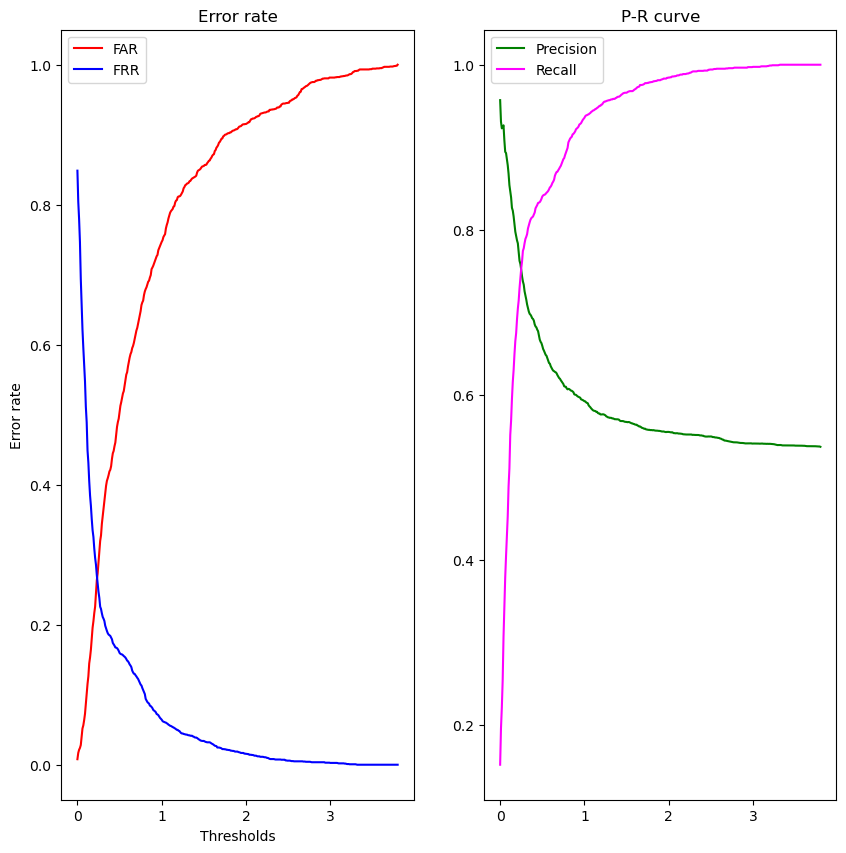

(0.7393806330987158, 0.21031622775713912)

In [50]:
acc, threshold = test_model(best_model_weight, p_model)
acc, threshold

#### Accuracy = 73.93% and Threshold = 0.21 Using Xavier Initialisation on Uniform distribution
Thus if the difference score is less than 0.21 we predict the test image as Genuine and if the difference score is greater than 0.21 we predict it to be as forged

#### Below we see some sample results

In [51]:
def predict_score():
    '''Predict distance score and classify test images as Genuine or Forged'''
    test_gen = generate_batch(orig_test, forg_test, 1)
    test_point, test_label = next(test_gen)
    img1, img2 = test_point[0], test_point[1]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 10))
    ax1.imshow(np.squeeze(img1), cmap='gray')
    ax2.imshow(np.squeeze(img2), cmap='gray')
    ax1.set_title('Genuine')
    if test_label == 1:
        ax2.set_title('Genuine')
    else:
        ax2.set_title('Forged')
    ax1.axis('off')
    ax2.axis('off')
    plt.show()
    result = p_model.predict([img1, img2])
    diff = result[0][0]
    print("Difference Score = ", diff)
    if diff > threshold:
        print("Its a Forged Signature")
    else:
        print("Its a Genuine Signature")

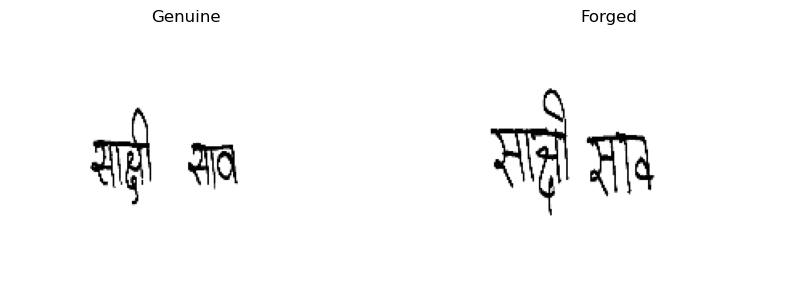

1/1 [==============================] - 1s 551ms/step
Difference Score =  1.550627
Its a Forged Signature


In [52]:
predict_score()

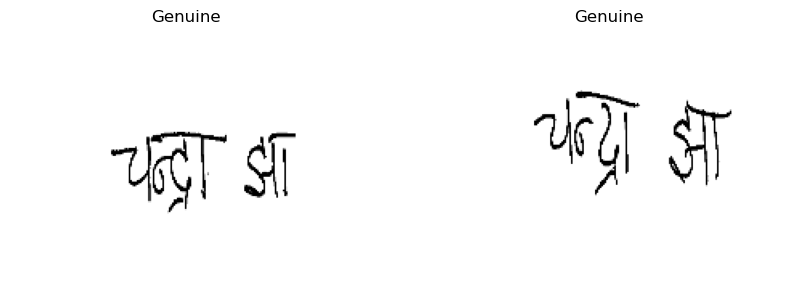

1/1 [==============================] - 1s 622ms/step
Difference Score =  0.105584405
Its a Genuine Signature


In [54]:
predict_score()

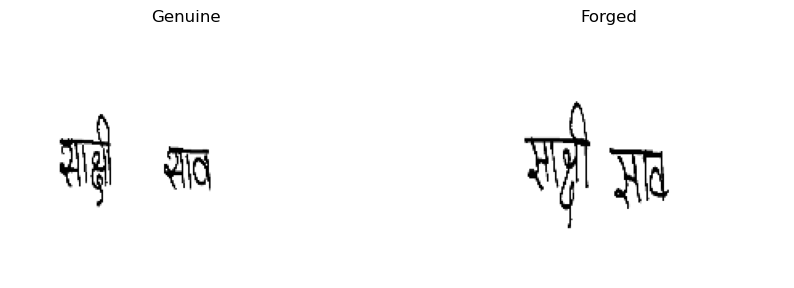

1/1 [==============================] - 0s 141ms/step
Difference Score =  0.07244001
Its a Genuine Signature


In [55]:
predict_score()